# Методы оптимизации.
## Домашнее задание 2 (Kaggle)
### Илья Игашов, 591 группа.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
import tqdm 
from PIL import Image 

Считываем названия картинок тренинговой выборки (в названии картинки написан класс, к которому она принадлежит).

In [2]:
%%bash 
ls train > train_files.txt

Из каждого пикселя картинки выделим синюю компоненту и посчитаем по ней распределение синего цвета в картинке. На основе этих распределений мы и будем классифицировать картинки (кажется, у картинок indoor и outdoor эти распределения должны сильно отличаться). Затем отнормируем вектор распределений так, чтобы его элементы принимали значения от 1 до -1. 

In [3]:
# Картинки обучающей выборки
with open('train_files.txt', 'r') as f:
    names = f.read().split('\n')[:-1]
    
x_train = []
y_train = []
for line in names:
    # Записываем класс каждой картинки в виде вектора вероятностей 
    # принадлежности картинки к каждому из двух классов
    if line[0] == 'i':
        # indoor
        y_train.append([1, 0])
    else:
        # outdoor
        y_train.append([0, 1])
     
    # Распределение синего цвета в картинке
    image = Image.open('train/' + line)
    pixels = np.array(list(image.getdata()))
    blue = pixels[:, 2]
    hist = np.histogram(blue)[0]
    x_train.append((hist - 512) / 1024)
x_train = np.array(x_train)
y_train = np.array(y_train)

In [4]:
# Картинки тестовой выборки
x_test = []
for i in range(2960):
    image = Image.open('test/img_' + str(i) + '.jpg')
    pixels = np.array(list(image.getdata()))
    blue = pixels[:, 2]
    hist = np.histogram(blue)[0]
    x_test.append((hist - 512) / 1024)
x_test = np.array(x_test)

In [6]:
def softmax(W,b,x):
    #todo - а можно ли написать лучше? и чем ваше решение лучше?
    tmp = np.exp(np.dot(x,W.T)+b)
    return (tmp.T/tmp.sum(axis=1)).T
    
def loss (y, pred):
    entropy = np.array([
            (y_t * np.log(y_p)).sum() 
            for y_t, y_p in zip(y, pred)
        ])
    return (-1) * np.average(entropy)

In [7]:
# Рассчитываем градиент
def compute_gradients(out,x,y):
    derivative = out - y
    grad_b = np.array(derivative)
    grad_W = np.matrix(derivative).T @ np.matrix(x)
    grad = np.vstack((grad_W.T, grad_b))
    return grad
    

# Усредняем по всем точкам
# После усреднения мы разделяем нашу матрицу размера 65x10 на матрицу 10x64 и вектор и возвращаем их.
def gradients(W,b,x,y):
    sm = softmax(W,b,x)        
    e = [ compute_gradients(a,b,c) for a,b,c in zip(sm,x,y) ]
    mean_grad = np.mean(e, axis=0)
    return np.delete(mean_grad, -1, axis=0).T, mean_grad[-1]

In [8]:
# Метод Армихо
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    s = 100
    while loss(y, softmax(W - s * dW, b - s * db, x)) > \
    loss(y, softmax(W, b, x)) - alpha * s * np.linalg.norm(np.vstack((dW.T, db))) ** 2:
        s *= beta
    return s

In [9]:
# Обучаем модель на тренинговой выборке
n_iter = 100
W = np.zeros((y_train.shape[1], x_train.shape[1]))
b = np.zeros(y_train.shape[1])
losses_train=[]

for i in tqdm.tqdm(range(n_iter)):
    losses_train.append(loss(y_train, softmax(W,b,x_train)))
    delta_W, delta_b = gradients(W,b,x_train,y_train)
    eta = armijo(W, b, x_train, y_train, delta_W, delta_b)
    W -= eta * delta_W
    b -= eta * delta_b

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Loss minimum on training data: 0.547588
Reached on 99 step


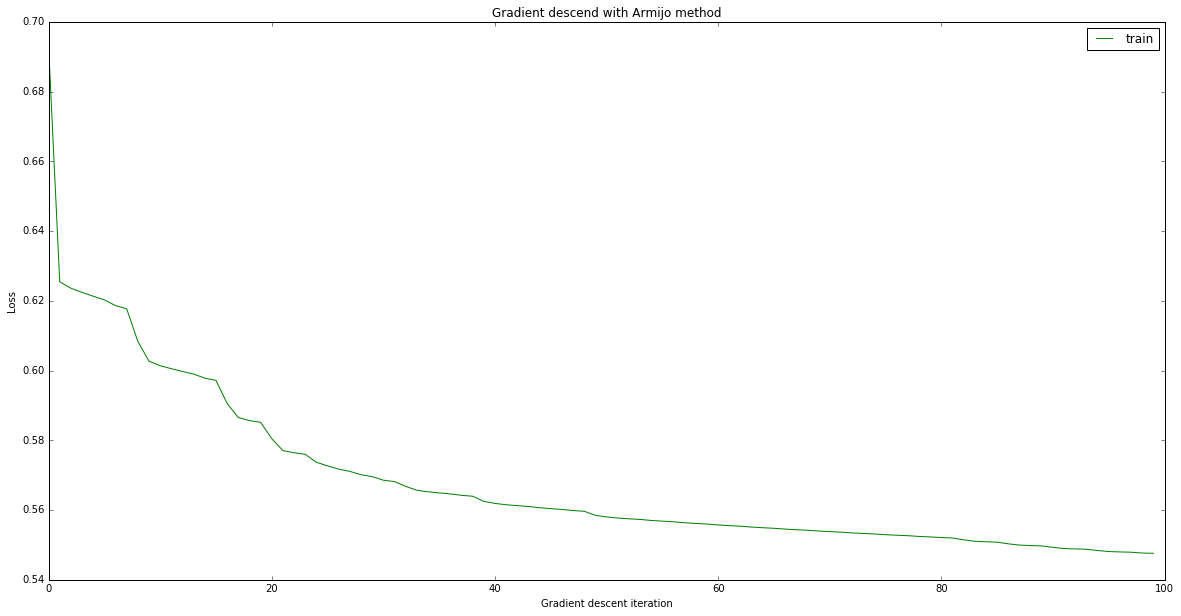

In [10]:
# Смотрим, что получилось
min_loss_train = np.min(losses_train)
min_loss_idx_train = np.argmin(losses_train)

print("Loss minimum on training data: %f" % min_loss_train)
print("Reached on %d step"% min_loss_idx_train)

plt.figure(figsize=(20, 10))
plt.plot(np.arange(n_iter), losses_train, color='green', label="train")
plt.title(r'Gradient descend with Armijo method')
plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Узнаем классы картинок тестовой выборки
y_pred = softmax(W,b,x_test)
print(y_pred[:5])

[[ 0.67745632  0.32254368]
 [ 0.63740428  0.36259572]
 [ 0.76375885  0.23624115]
 [ 0.73651723  0.26348277]
 [ 0.52267986  0.47732014]]


In [12]:
# Записываем в файл результат в нужном формате для Kaggle
with open('prediction.csv', 'w') as f:
    f.write('id,res\n')
    for i, p in enumerate(y_pred):
        f.write(str(i) + ',' + str(p[0]) + '\n')